## Looking for markers for1 ASJ, ASH using only Taylor 2020 data

In [1]:
### Installation and imports


# If running in Colab, navigate to Runtime -> Change runtime type
# and ensure you're using a Python 3 runtime with GPU hardware accelerator
# Installation of scVI in Colab can take several minutes
import sys
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    !pip install scvi-tools --quiet
    !pip install opentsne --quiet
    !pip install scanpy --quiet



In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# Control warnings
import warnings; warnings.simplefilter('ignore')

import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

import torch
import anndata
from tqdm import tqdm
from umap import UMAP
from openTSNE import TSNE
import scanpy as sc 
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import Image
import scvi
scvi.__version__


'0.7.1'

In [3]:
taylor2020 = anndata.read('taylor2020.h5ad')

taylor2020.obs['study']='taylor2020'
taylor2020.obs['experiment']=taylor2020.obs['experiment_code']

adata=taylor2020
display(adata.obs.head(3))
display(adata.var.head(3))


,dropbox_id,counts,experiment_code,cell_type,tissue,study,experiment
1806-ST-1-AAACCTGAGAGACGAA,1806-ST-1,65,Pan-1,Unannotated,Unannotated,taylor2020,Pan-1
1806-ST-1-AAACCTGAGGTAAACT,1806-ST-1,367,Pan-1,AVF,Neuron,taylor2020,Pan-1
1806-ST-1-AAACCTGAGGTAGCCA,1806-ST-1,1792,Pan-1,AVH,Neuron,taylor2020,Pan-1


""
gene_id
WBGene00014450
WBGene00014451
WBGene00010957


In [6]:
## let's remove genes with less than 100 counts across all samples
mincounts = 100
nremoved = np.sum(adata.X.sum(0) < mincounts)
print('Removing ', nremoved, ' genes with less than ', mincounts, 'counts')
adata = adata[:,(adata.X.sum(0) > mincounts)]
adata

Removing  31195  genes with less than  100 counts


View of AnnData object with n_obs × n_vars = 100955 × 15692
    obs: 'dropbox_id', 'counts', 'experiment_code', 'cell_type', 'tissue', 'study', 'experiment'

## Define and train the model

We now create the model and the trainer object. We train the model and output model likelihood every epoch. 

If a pre-trained model already exist in the save_path then load the same model rather than re-training it. This is particularly useful for large datasets.

In [7]:
adata.obs

,dropbox_id,counts,experiment_code,cell_type,tissue,study,experiment
1806-ST-1-AAACCTGAGAGACGAA,1806-ST-1,65,Pan-1,Unannotated,Unannotated,taylor2020,Pan-1
1806-ST-1-AAACCTGAGGTAAACT,1806-ST-1,367,Pan-1,AVF,Neuron,taylor2020,Pan-1
1806-ST-1-AAACCTGAGGTAGCCA,1806-ST-1,1792,Pan-1,AVH,Neuron,taylor2020,Pan-1
1806-ST-1-AAACCTGAGTAACCCT,1806-ST-1,1229,Pan-1,RIA,Neuron,taylor2020,Pan-1
1806-ST-1-AAACCTGAGTACGCGA,1806-ST-1,1401,Pan-1,AUA,Neuron,taylor2020,Pan-1
...,...,...,...,...,...,...,...
4170-ST-1-TTTGTTGCACTATCCC,4170-ST-1,2356,ceh-28_dat-1,Body_wall_muscle_anterior,Muscle_mesoderm,taylor2020,ceh-28_dat-1
4170-ST-1-TTTGTTGGTGGATCAG,4170-ST-1,1382,ceh-28_dat-1,PLN,Neuron,taylor2020,ceh-28_dat-1
4170-ST-1-TTTGTTGGTTTCGTTT,4170-ST-1,614,ceh-28_dat-1,Gonadal_sheath_cell,Reproductive,taylor2020,ceh-28_dat-1
4170-ST-1-TTTGTTGTCAGCCCAG,4170-ST-1,209,ceh-28_dat-1,Uterine_cell,Reproductive,taylor2020,ceh-28_dat-1


In [8]:
## set up the adata with scvi 

adata.layers["counts"] = adata.X.copy() # preserve counts
scvi.data.setup_anndata(adata, layer="counts", batch_key='experiment') 


INFO      Using batches from adata.obs["experiment"]                                         
INFO      No label_key inputted, assuming all cells have same label                          
INFO      Using data from adata.layers["counts"]                                             
INFO      Computing library size prior per batch                                             
INFO      Successfully registered anndata object containing 100955 cells, 15692 vars, 17     
          batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates  
          and 0 extra continuous covariates.                                                 
INFO      Please do not further modify adata until model is trained.                         


In [9]:
## specify the scvi model properties

model = scvi.model.SCVI(adata,  
                        n_hidden=128, 
                        n_layers=2,
                        gene_likelihood='nb',
                        dispersion='gene-batch'
                        )


INFO      Training for 20 epochs                                                             
INFO      Training without KL warmup                                                         
Training...: 100%|██████████| 20/20 [05:26<00:00, 16.32s/it]
INFO      Training time:  209 s. / 20 epochs                                                 


<AxesSubplot:>

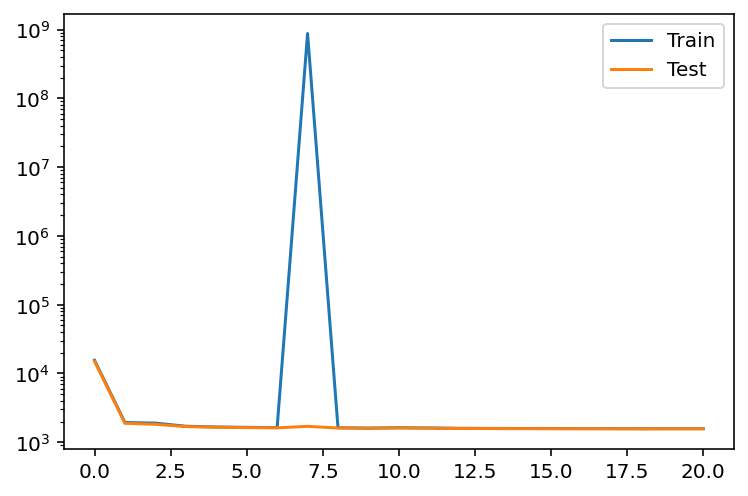

In [10]:
## train the model
## for this dataset 5 epochs is sufficient 
## with a GPU each epoch should take < 60s

model.train(frequency=1, 
            n_epochs = 20,
            lr=2e-3,
            n_epochs_kl_warmup=None)


## once done plot the train test results to ensture the model finished training
train_test_results = pd.DataFrame(model.trainer.history).rename(columns={'elbo_train_set':'Train', 'elbo_test_set':'Test'})
train_test_results.plot(logy=True)

## to save and load the model uncomment the lines below
# model.save("my_model/")
# model = scvi.model.SCVI.load("my_model/", adata, use_cuda=True)


In [11]:
## from the trained model get the scvi latent space coordinates and store in the anndata
latent = model.get_latent_representation() # get latent

## the latent space by default is 10 dimensional, so it shape should be 10 x ncells
print(latent.shape) 
## storing the latent space in the anndata allows interoperability with scanpy
adata.obsm["X_scVI"] = latent

## we also retrieve the scvi expression frequency, akin to normalized expression in other workflows
adata.layers["scvi_expression_frequency"] = model.get_normalized_expression(return_mean=True, return_numpy=True)

(100955, 10)


In [121]:
cells_of_interest = ['ASH', 'ASJ','LUA']
studies_of_interest = ['taylor2020']


In [122]:
for c in cells_of_interest:
    print(c)
    print(adata.obs[adata.obs.cell_type==c].experiment.value_counts())

ASH
ift-20          324
eat-4           183
Pan-2            24
Pan-1            19
acr-2            14
unc-53            7
ceh-34            6
unc-3             4
tph-1_ceh-10      4
ceh-28_dat-1      4
unc-47_2          3
cho-1_2           2
cho-1_1           2
nmr-1             1
nlp-13_ceh-2      1
unc-47_1          0
unc-86            0
Name: experiment, dtype: int64
ASJ
ift-20          409
ceh-28_dat-1    396
Pan-2           144
cho-1_1          91
cho-1_2          87
Pan-1            37
eat-4            24
acr-2            24
unc-3            13
ceh-34           10
unc-47_2          9
tph-1_ceh-10      8
unc-53            7
unc-86            5
nlp-13_ceh-2      2
nmr-1             0
unc-47_1          0
Name: experiment, dtype: int64
LUA
eat-4           20
Pan-2           18
Pan-1           11
ceh-28_dat-1    10
unc-86           8
unc-53           3
cho-1_1          2
nmr-1            1
nlp-13_ceh-2     1
unc-3            1
cho-1_2          1
acr-2            1
tph-1_ceh-10     0

# Make swarm plots for ASJ, ASH


In [123]:
### This checks how many cells of each type of interest are found in each study
### If there are cells in at least a few studies then proceed to DE and create the swarm plots
print('\n Checking how many `cells_of_interest` are present in each study...')
for study in studies_of_interest:
    print('\n \n 🔹 🔹 🔹 🔹 🔹 🔹 🔹 🔹 Cell counts for:', study, ' 🔹 🔹 🔹 🔹 🔹 🔹 🔹 🔹   ')
    adata_study=adata[adata.obs.study==study]
    for cell_type_1 in cells_of_interest:  
        cell_idx1 = adata_study[adata_study.obs['cell_type'] == cell_type_1].obs.index
        ncells1=len(cell_idx1)
        if ncells1==0:
            print(' 🛑 🛑 🛑 \t  0 \t', cell_type_1, ' \t cells in ', study, ' \t 🛑 🛑 🛑 ')
            continue
        print(' ✅ ✅ ✅ \t ',ncells1,'\t',  cell_type_1, ' \t cells in ', study, ' \t ✅ ✅ ✅ ')


 Checking how many `cells_of_interest` are present in each study...

 
 🔹 🔹 🔹 🔹 🔹 🔹 🔹 🔹 Cell counts for: taylor2020  🔹 🔹 🔹 🔹 🔹 🔹 🔹 🔹   
 ✅ ✅ ✅ 	  598 	 ASH  	 cells in  taylor2020  	 ✅ ✅ ✅ 
 ✅ ✅ ✅ 	  1266 	 ASJ  	 cells in  taylor2020  	 ✅ ✅ ✅ 
 ✅ ✅ ✅ 	  77 	 LUA  	 cells in  taylor2020  	 ✅ ✅ ✅ 


In [126]:
## perform DE against ALL cells for swarm plot

# allde={}

for study in studies_of_interest:
    print('\n \n 🔹 🔹 🔹 🔹 🔹 🔹 🔹 🔹 Cell counts for:', study, ' 🔹 🔹 🔹 🔹 🔹 🔹 🔹 🔹   ')
    adata_study=adata[adata.obs.study==study]
#     for cell_type_1 in ['LUA']:  
    for cell_type_1 in cells_of_interest:  
        cell_idx1 = adata_study[adata_study.obs['cell_type'] == cell_type_1].obs.index
        ncells1=len(cell_idx1)
        if ncells1==0:
            print(' 🛑 🛑 🛑 \t  0 \t', cell_type_1, ' \t cells in ', study, ' \t SKIPPING... 🛑 🛑 🛑 ')
            continue
        print(' ✅ ✅ ✅ \t ',ncells1,'\t',  cell_type_1, ' \t cells in ', study, ' \t PERFORMING DE AGAINST... ✅ ✅ ✅ ')
        
        cell_types_in_study = np.sort(adata[adata.obs.study==study].obs.cell_type.unique())
        print(len(cell_types_in_study), ' CELL TYPES: ')
        print(cell_types_in_study)
        
        allde[cell_type_1+study]=pd.DataFrame()  
        for cell_type_2 in cell_types_in_study:

            cell_idx2 = adata_study[adata_study.obs['cell_type'] == cell_type_2].obs.index
            ncells2=len(cell_idx2)
            print(ncells2, ' \t ' +  str(cell_type_2) +  '  \t \t  \t vs  ', ncells1, cell_type_1, ' in ', study)

            if cell_type_1==cell_type_2:
#                 print(cell_type_1, cell_type_2, '...skipping...')
                continue




            ###### DE CHANGE ############
            de = model.differential_expression(
                idx1 = adata.obs.index.isin(cell_idx1), 
                idx2 = adata.obs.index.isin(cell_idx2), 
                mode='change'
                )
            de['comparison']=cell_type_2
            allde[cell_type_1+study] = allde[cell_type_1+study].append(de)
            
        ### Save DE results in one folder per cell type per study    
        savename = 'DE_results_' + cell_type_1+'_'+ study
#         if not os.path.exists(savename): os.makedirs(savename)    
        allde[cell_type_1+study].to_csv(savename+'.csv')


 
 🔹 🔹 🔹 🔹 🔹 🔹 🔹 🔹 Cell counts for: taylor2020  🔹 🔹 🔹 🔹 🔹 🔹 🔹 🔹   
 ✅ ✅ ✅ 	  598 	 ASH  	 cells in  taylor2020  	 PERFORMING DE AGAINST... ✅ ✅ ✅ 
169  CELL TYPES: 
['ADA' 'ADE' 'ADF' 'ADL' 'AFD' 'AIA' 'AIB' 'AIM' 'AIN' 'AIY' 'AIZ' 'ALA'
 'ALM' 'ALN' 'AMsh' 'AMso' 'AQR' 'AS' 'ASEL' 'ASER' 'ASG' 'ASH' 'ASI'
 'ASJ' 'ASK' 'AUA' 'AVA' 'AVB' 'AVD' 'AVE' 'AVF' 'AVG' 'AVH' 'AVJ' 'AVK'
 'AVL' 'AVM' 'AWA' 'AWB' 'AWC_OFF' 'AWC_ON' 'Anal_muscle' 'Arcade_cell'
 'BAG' 'BDU' 'Body_wall_muscle' 'Body_wall_muscle_anterior' 'CAN' 'CEP'
 'CEPsh' 'Coelomocyte' 'DA' 'DA9' 'DB' 'DB01' 'DVA' 'DVB' 'DVC'
 'Distal_tip_cell' 'Epidermis' 'Excretory_cell' 'Excretory_gland_cell'
 'FLP' 'Germline' 'Glia_1' 'Glia_2' 'Glia_3' 'Glia_4' 'Glia_5'
 'Gonadal_sheath_cell' 'HSN' 'I1' 'I2' 'I3' 'I4' 'I5' 'I6' 'IL1' 'IL2_DV'
 'IL2_LR' 'Intestine' 'LUA' 'M1' 'M2' 'M3' 'M4' 'M5' 'MC' 'MI'
 'Marginal_cell' 'NSM' 'OLL' 'OLQ' 'PDA' 'PDB' 'PDE' 'PHA' 'PHB' 'PHC'
 'PHsh' 'PHso' 'PLM' 'PLN' 'PQR' 'PVC' 'PVD' 'PVM' 'PVN' 'PVP' 'PVQ' 

In [95]:
genedesc = pd.read_csv('../celegans_gene_descriptions.csv', index_col=0)
genemaps = pd.read_csv('../worm_gene_name_id.csv', index_col=1)


In [96]:
name2id=genemaps.set_index('gene_name')
name2id['gene_id']=genemaps.index
# name2id

In [97]:
#ASJ: pps-1, F47D2.11, srw-10.
#ASH: nlp-76, T23B3.6, srh-15

mark_candidates = name2id.loc[['pps-1', 'F47D2.11','srw-10', 'nlp-76', 'T23B3.6', 'srh-15']]
mark_candidates['neuron'] = ['ASJ','ASJ','ASJ','ASH','ASH','ASH']
mark_candidates

,gene_id,neuron
gene_name,,
pps-1,WBGene00004091,ASJ
F47D2.11,WBGene00206392,ASJ
srw-10,WBGene00005757,ASJ
nlp-76,WBGene00045386,ASH
T23B3.6,WBGene00020714,ASH
srh-15,WBGene00005240,ASH


In [99]:
cells_of_interest

['ASH', 'ASJ']

In [127]:
globalde={}
for cell_type_1 in cells_of_interest:  
    print(cell_type_1)
    globalde[cell_type_1+study] = model.differential_expression(
                    group1=cell_type_1, 
                    groupby='cell_type',
                    mode='change'
                    )

ASH
DE...: 100%|██████████| 1/1 [00:09<00:00,  9.95s/it]
ASJ
DE...: 100%|██████████| 1/1 [00:09<00:00,  9.86s/it]
LUA
DE...: 100%|██████████| 1/1 [00:09<00:00,  9.89s/it]


In [ ]:
dedfs = globalde

In [ ]:
dedfs[cell_type_1+study][dedfs[cell_type_1+study].index.isin(mark_candidates.gene_id.values)].copy()    


In [119]:
sel_genes[::-1]

gene_id
WBGene00045386    WBGene00045386
WBGene00005240    WBGene00005240
WBGene00004091    WBGene00004091
WBGene00020714    WBGene00020714
WBGene00005757    WBGene00005757
WBGene00005319    WBGene00005319
WBGene00005808    WBGene00005808
WBGene00013912    WBGene00013912
WBGene00018626    WBGene00018626
WBGene00005756    WBGene00005756
WBGene00008286    WBGene00008286
WBGene00189947    WBGene00189947
WBGene00005755    WBGene00005755
WBGene00006272    WBGene00006272
WBGene00010764    WBGene00010764
WBGene00006148    WBGene00006148
WBGene00013748    WBGene00013748
WBGene00012064    WBGene00012064
WBGene00005937    WBGene00005937
WBGene00005144    WBGene00005144
WBGene00006103    WBGene00006103
WBGene00005178    WBGene00005178
WBGene00005511    WBGene00005511
WBGene00044419    WBGene00044419
WBGene00005843    WBGene00005843
WBGene00005241    WBGene00005241
WBGene00005676    WBGene00005676
WBGene00044228    WBGene00044228
WBGene00014827    WBGene00014827
WBGene00005433    WBGene00005433
WB

In [ ]:
dedfs = globalde
for study in studies_of_interest:
    print('\n \n 🔹 🔹 🔹 🔹 🔹 🔹 🔹 🔹 Cell counts for:', study, ' 🔹 🔹 🔹 🔹 🔹 🔹 🔹 🔹   ')
    adata_study=adata[adata.obs.study==study]
    for cell_type_1 in ['LUA']:#cells_of_interest:  
        cell_idx1 = adata_study[adata_study.obs['cell_type'] == cell_type_1].obs.index
        ncells1=len(cell_idx1)
        if ncells1==0:
            print(' 🛑 🛑 🛑 \t  0 \t', cell_type_1, ' \t cells in ', study, ' \t SKIPPING... 🛑 🛑 🛑 ')
            continue
        print(' ✅ ✅ ✅ \t ',ncells1,'\t',  cell_type_1, ' \t cells in ', study, ' \t MAKING SWARM PLOT FOR... ✅ ✅ ✅ ')
        cell_types_in_study = np.sort(adata[adata.obs.study==study].obs.cell_type.unique())
        print(len(cell_types_in_study), ' CELL TYPES: ')
        print(cell_types_in_study)
        
        # sort display order by median log fold change
        #select positive lfc
        sel=dedfs[cell_type_1+study][dedfs[cell_type_1+study].lfc_mean>0].copy()
        sel['gene_id']=sel.index
        # sort by p value, select top n
        n_top_selection = 500
        sel = sel.sort_values(by='proba_not_de', ascending=True).head(n_top_selection)

        # append genes of interest, they will be highlighted as red
        markersdf = dedfs[cell_type_1+study][dedfs[cell_type_1+study].index.isin(mark_candidates.gene_id.values)].copy()    
    
#         sel = sel.append(markersdf).sort_values(by='proba_not_de', ascending=True)
        sel['gene_id']=sel.index
        sel_genes=sel['gene_id']

        data = []    
        for gene_id, _gene_id in sel_genes[::-1].iteritems():
            gene_name=genemaps.loc[gene_id]['gene_name']

            dedf=allde[cell_type_1+study][allde[cell_type_1+study].index==gene_id].copy()
            color = 'rgb(0, 0, 0)'
            if gene_id in mark_candidates.gene_id.values: color = 'rgb(255, 0, 0)'

            trace = go.Box(
             x=-np.round(dedf['lfc_mean'],3), boxpoints = 'all', pointpos = 0
            , marker = dict(color = color)
            , line = dict(color = 'rgba(0,0,0,0)')
            , fillcolor = 'rgba(0,0,0,0)'
            , opacity=1
            , marker_size=4  
            , name = gene_name  + ' \t e=' + f"{dedf['scale1'][0]:.1E}" #+ ' | p=' + f"{sel[sel.gene_id==gene_id]['proba_not_de'][0]:.1E}"
            , hoverinfo='text'
            , text=dedf['comparison'].values + '<br>' + gene_name
            , customdata=np.round(-np.log10(dedf['scale2'].values),2).astype(str)
            , hovertemplate='%{text} <br>Base expression: %{customdata} <br>' +
                            'log fold change: %{y}<br>' +'<extra></extra>'
        #                     '<extra>%{text}</extra>'
            )
            data.append(trace)
        title= ' Relative log fold change in expression of top ' +str(n_top_selection) + ' ' + cell_type_1 + ' specific genes in ' + study
        layout = go.Layout(title=title
#                            , width=750
                           , height=n_top_selection*20
                          )
        fig = go.Figure(data, layout)
        fig.update_layout(showlegend=False, template='none')
        fig.update_xaxes(tickangle=90, tickfont=dict( color='black', size=12),automargin=True)
        fig.update_yaxes(automargin=True)
        fig.update_layout(hovermode="closest")
        title='./' + cell_type_1+study + '_top'+str(n_top_selection)+'_swarmplot2.html'
        print(title)
        fig.write_html(title)
    #     fig.show()
print('DONE!')


 
 🔹 🔹 🔹 🔹 🔹 🔹 🔹 🔹 Cell counts for: taylor2020  🔹 🔹 🔹 🔹 🔹 🔹 🔹 🔹   
 ✅ ✅ ✅ 	  77 	 LUA  	 cells in  taylor2020  	 MAKING SWARM PLOT FOR... ✅ ✅ ✅ 
169  CELL TYPES: 
['ADA' 'ADE' 'ADF' 'ADL' 'AFD' 'AIA' 'AIB' 'AIM' 'AIN' 'AIY' 'AIZ' 'ALA'
 'ALM' 'ALN' 'AMsh' 'AMso' 'AQR' 'AS' 'ASEL' 'ASER' 'ASG' 'ASH' 'ASI'
 'ASJ' 'ASK' 'AUA' 'AVA' 'AVB' 'AVD' 'AVE' 'AVF' 'AVG' 'AVH' 'AVJ' 'AVK'
 'AVL' 'AVM' 'AWA' 'AWB' 'AWC_OFF' 'AWC_ON' 'Anal_muscle' 'Arcade_cell'
 'BAG' 'BDU' 'Body_wall_muscle' 'Body_wall_muscle_anterior' 'CAN' 'CEP'
 'CEPsh' 'Coelomocyte' 'DA' 'DA9' 'DB' 'DB01' 'DVA' 'DVB' 'DVC'
 'Distal_tip_cell' 'Epidermis' 'Excretory_cell' 'Excretory_gland_cell'
 'FLP' 'Germline' 'Glia_1' 'Glia_2' 'Glia_3' 'Glia_4' 'Glia_5'
 'Gonadal_sheath_cell' 'HSN' 'I1' 'I2' 'I3' 'I4' 'I5' 'I6' 'IL1' 'IL2_DV'
 'IL2_LR' 'Intestine' 'LUA' 'M1' 'M2' 'M3' 'M4' 'M5' 'MC' 'MI'
 'Marginal_cell' 'NSM' 'OLL' 'OLQ' 'PDA' 'PDB' 'PDE' 'PHA' 'PHB' 'PHC'
 'PHsh' 'PHso' 'PLM' 'PLN' 'PQR' 'PVC' 'PVD' 'PVM' 'PVN' 'PVP' 'PVQ' '

In [ ]:
foo

In [134]:
ff

NameError: name 'ff' is not defined